In [92]:
import keras

In [93]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Merge, Reshape
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD

In [94]:
import pandas as pd
import feather

In [95]:
df_shop_info = feather.read_dataframe('data/df_shop_info.feather')

In [96]:
from sklearn.preprocessing import LabelEncoder

In [97]:
df_shop_info = feather.read_dataframe('data/df_shop_info.feather')

df_shop_info['city_name'] = LabelEncoder().fit_transform(df_shop_info.city_name)
df_shop_info['category_1'] = LabelEncoder().fit_transform(df_shop_info.category_1)
df_shop_info['category_2'] = LabelEncoder().fit_transform(df_shop_info.category_2)
df_shop_info['category_3'] = LabelEncoder().fit_transform(df_shop_info.category_3)

df_shop_info = df_shop_info[['city_name', 'location_id', 'category_1', 'category_2', 'category_3']]

In [99]:
for c in df_shop_info.columns:
    print(c, df_shop_info[c].nunique())

city_name 122
location_id 1159
category_1 6
category_2 17
category_3 44


In [100]:
df_pays = feather.read_dataframe('data/df_pays_na_test.feather')

In [103]:
df_pays_info = pd.concat([df_pays, df_shop_info.iloc[df_pays.shop_id - 1].reset_index(drop=1)], axis=1)

In [105]:
from outliers import remove_outliers

In [106]:
from tqdm import tqdm

In [107]:
shops = df_pays.shop_id.unique()
shops = sorted(shops)

dfs = []

for i in tqdm(shops):
    df_shop = df_pays_info[df_pays_info.shop_id == i].reset_index(drop=1)
    remove_outliers(df_shop)
    df = df_shop.iloc[7 * 2 * 3:]
    dfs.append(df)

df_features = pd.concat(dfs).reset_index(drop=1)

100%|██████████| 2000/2000 [00:16<00:00, 120.59it/s]


In [108]:
df_all = df_features[df_features.biweek_id > 0].reset_index(drop=1)
df_all = df_all[~df_all.pays_count.isnull()].reset_index(drop=1)

In [109]:
df_all.shop_id = df_all.shop_id - 1
df_all.location_id = df_all.location_id - 1

In [110]:
feature_cols = ['dow', 'shop_id', 'location_id', 'city_name', 'category_1', 'category_2', 'category_3']

In [111]:
X = df_all[feature_cols].values

In [112]:
def prepare_train_data(X):
    _, d = X.shape
    res = []
    for i in range(d):
        res.append(X[:, [i]])
    return res

In [113]:
X_l = prepare_train_data(X)

In [114]:
y = np.log1p(df_all.pays_count.values)

In [115]:
import numpy as np

In [116]:
import keras.backend as K

def rmse(y_true, y_pred):
    mse = (y_true - y_pred) ** 2
    return K.mean(K.sqrt(mse))

In [117]:
models = []

model_dow = Sequential()
model_dow.add(Embedding(7, 6, input_length=1))
model_dow.add(Reshape(target_shape=(6,)))
models.append(model_dow)

model_shop = Sequential()
model_shop.add(Embedding(2000, 12, input_length=1))
model_shop.add(Reshape(target_shape=(12,)))
models.append(model_shop)

model_loc = Sequential()
model_loc.add(Embedding(1159, 10, input_length=1))
model_loc.add(Reshape(target_shape=(10,)))
models.append(model_loc)

model_city = Sequential()
model_city.add(Embedding(122, 8, input_length=1))
model_city.add(Reshape(target_shape=(8,)))
models.append(model_city)

model_cat1 = Sequential()
model_cat1.add(Embedding(6, 2, input_length=1))
model_cat1.add(Reshape(target_shape=(2,)))
models.append(model_cat1)

model_cat2 = Sequential()
model_cat2.add(Embedding(17, 3, input_length=1))
model_cat2.add(Reshape(target_shape=(3,)))
models.append(model_cat2)

model_cat3 = Sequential()
model_cat3.add(Embedding(44, 4, input_length=1))
model_cat3.add(Reshape(target_shape=(4,)))
models.append(model_cat3)

model = Sequential()
model.add(Merge(models, mode='concat'))

model.add(Dense(1000, init='uniform'))
model.add(Activation('relu'))

model.add(Dense(500, init='uniform'))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('linear'))


sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', metrics=[rmse],  optimizer=sgd)

In [118]:
model.fit(X_l, y, batch_size=4000, validation_split=0.1)

Train on 461408 samples, validate on 51268 samples
Epoch 1/10
461408/461408 [==============================] - 24s - loss: 3.0350 - rmse: 1.1633 - val_loss: 0.7000 - val_rmse: 0.6276
Epoch 2/10
461408/461408 [==============================] - 16s - loss: 0.5906 - rmse: 0.5744 - val_loss: 0.6975 - val_rmse: 0.6268
Epoch 3/10
461408/461408 [==============================] - 16s - loss: 0.5876 - rmse: 0.5731 - val_loss: 0.6942 - val_rmse: 0.6258
Epoch 4/10
461408/461408 [==============================] - 16s - loss: 0.5831 - rmse: 0.5712 - val_loss: 0.6883 - val_rmse: 0.6239
Epoch 5/10
461408/461408 [==============================] - 17s - loss: 0.5764 - rmse: 0.5685 - val_loss: 0.6819 - val_rmse: 0.6225
Epoch 6/10
461408/461408 [==============================] - 16s - loss: 0.5677 - rmse: 0.5650 - val_loss: 0.6735 - val_rmse: 0.6204
Epoch 7/10
461408/461408 [==============================] - 17s - loss: 0.5582 - rmse: 0.5614 - val_loss: 0.6643 - val_rmse: 0.6177
Epoch 8/10
461408/461408 

In [119]:
p = model.predict(X_l)

In [41]:
import seaborn as sns
%matplotlib inline

In [44]:
import matplotlib.pyplot as plt

/home/agrigorev/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


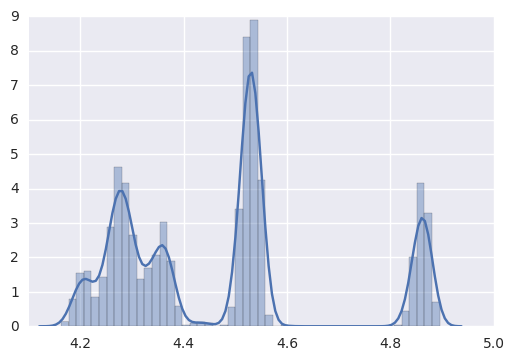

In [120]:
sns.distplot(p[:, 0])
#sns.distplot(y)

/home/agrigorev/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


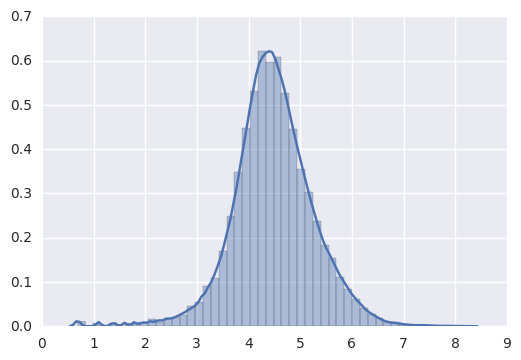

In [128]:
#sns.distplot(p[:, 0])
sns.distplot(y)

In [122]:
embedding = {c: m.get_weights()[0] for (c, m) in zip(feature_cols, models)}

In [123]:
df_features.shop_id = df_features.shop_id - 1 
df_features.location_id = df_features.location_id - 1

In [124]:
for c in feature_cols:
    W = embedding[c]
    idx = df_features[c].values
    data = W[idx, :]
    
    _, d = data.shape
    
    for i in range(d):
        df_features['%s_%d' % (c, i)] = data[:, i]
    
    if c not in ['dow', 'shop_id']:
        del df_features[c]

In [125]:
df_features.shop_id = df_features.shop_id + 1 

In [126]:
len(df_features)

581010

In [127]:
feather.write_dataframe(df_features, 'features/entity_embedding.feather')